# Capstone Project

## Introduction


Chicago, officially the City of Chicago, is the most populous city in the U.S. state of Illinois and the third most populous city in the United States. With an estimated population of 2,705,994 (2018), it is also the most populous city in the Midwestern United States. Chicago is the county seat of Cook County, the second most populous county in the US, with portions of the northwest city limits extending into DuPage County near O'Hare Airport. Chicago is the principal city of the Chicago metropolitan area, often referred to as Chicagoland. At nearly 10 million people, the metropolitan area is the third most populous in the nation.

Chicago is an international hub for finance, culture, commerce, industry, education, technology, telecommunications, and transportation. It is the site of the creation of the first standardized futures contracts, issued by the Chicago Board of Trade, which today is the largest and most diverse derivatives market in the world, generating 20% of all volume in commodities and financial futures alone. The Chicago area has one of the highest gross domestic products (GDP) in the world, generating $680 billion in 2017. In addition, the city has one of the world's most diversified and balanced economies, with no single industry employing more than 14 percent of the workforce. Chicago is home to several Fortune 500 companies, including Allstate, Boeing, Exelon, Kraft Heinz, McDonald's, Mondelez International, Sears, United Airlines Holdings, and Walgreens.

Chicago's 58 million domestic and international visitors in 2018 made it the second most visited city in the nation, not far behind New York City's 65 million visitors in 2018. The city was ranked first in the 2018 Time Out City Life Index, a global quality of life survey of 15,000 people in 32 cities. Landmarks in the city include Millennium Park, Navy Pier, the Magnificent Mile, the Art Institute of Chicago, Museum Campus, the Willis (Sears) Tower, Grant Park, the Museum of Science and Industry, and Lincoln Park Zoo. Chicago's culture includes the visual arts, literature, film, theatre, comedy (especially improvisational comedy), food, and music, particularly jazz, blues, soul, hip-hop, gospel, and electronic dance music including house music.

This also means that the market is highly competitive. As it is highly developed city so cost of doing
business is also one of the highest. Thus, any new business venture or expansion needs to be analysed
carefully. The insights derived from analysis will give good understanding of the business
environment which help in strategically targeting the market. This will help in reduction of risk, and
the Return on Investment will be reasonable. 

## Business problem


Our Client has asked to research the are of Chicago for the possibility of new Movie theaters in the area. Our goal is to identify the suitable places, that have land areas available for purchase from City Govt. as well.

## Find a suitable and available location. 

If you plan a movie theater that provides best environemnt for entertainment, you need to look for an area greater than 5K sq/ft. So, we need to look for areas which have suitable areas for opening a movie theater.

## Data Collection

We will look for a suitable place for our business based on neihborhoods in City of Chicago. For this we need relevant data to go ahead with our analysis. Data will be collected from the following, we will need names of neighborhoods, zip codes, lat,lng for map marking

- **For NeigbourHood names**: https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago

- **For Zip Codes** https://data.cityofchicago.org/api/views/unjd-c2ca/rows.csv?accessType=DOWNLOAD

- **For Lat Lng** https://simplemaps.com/data/us-zips

- **FourSquare API for Venues** https://developer.foursquare.com/docs/resources/categories

After that we will form clusters and analyze which cluster have space/land for commercial activity for this data will be obatined from the following.
- **Chicago City Owned Lands**  https://data.cityofchicago.org/Community-Economic-Development/City-Owned-Land-Inventory/aksk-kvfp/data

### Setting up the environment

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
import geocoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
import folium

## Geting Neighborhoods for City of Chicago

### Parsing the html

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'
page = urlopen(url).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

###  Extracting data from the table to the data frame

In [3]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

In [4]:
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 2:
            continue
        data.append(row)        
    
    return data

In [5]:
data = get_row()
columns = ['Neighborhood', 'Community Area']
df = pd.DataFrame(data, columns=columns)
df.head()

,Neighborhood,Community Area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [6]:
df.shape

(246, 2)

###  Cleaning the data

In [7]:
df = df[df.Neighborhood != 'Not assigned']
df = df.sort_values(by=['Neighborhood','Community Area'])

df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

df.head()

,Neighborhood,Community Area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [8]:
df.shape

(246, 2)

We have our Neighborhoods but we need more info to get geographical locations. One way is to use ZipCodes and [this city of chicago website](https://data.cityofchicago.org/api/views/unjd-c2ca/rows.csv?accessType=DOWNLOAD) provides relevant data.

In [9]:
df_zip=pd.read_csv('Zip_Codes.csv')
df_zip.head()

,the_geom,OBJECTID,ZIP,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.67762151065281 41.91775780...,33,60647,1.060523e+08,42720.044406
1,MULTIPOLYGON (((-87.72683253163021 41.92264626...,34,60639,1.274761e+08,48103.782721
2,MULTIPOLYGON (((-87.78500237831095 41.90914785...,35,60707,4.506904e+07,27288.609612
3,MULTIPOLYGON (((-87.6670686895295 41.888851884...,36,60622,7.085383e+07,42527.989679
4,MULTIPOLYGON (((-87.70655631674127 41.89555340...,37,60651,9.903962e+07,47970.140153


We only need ZIP column

In [10]:
df_zip=df_zip['ZIP']

In [11]:
df_zip=pd.DataFrame(df_zip)
df_zip.head()

,ZIP
0,60647
1,60639
2,60707
3,60622
4,60651


We have Zip codes but we don't know, which Zip codes fall in which neigbourhood or what there lat, lng is so, we need to look for some data that can either provide some info that could help us in mapping these zip codes to lat lng and then to neigborhoods. The data set at [SimpleMaps](https://simplemaps.com/data/us-zips) provide us with this info. So, we will use it.

In [12]:
df3=pd.read_csv('uszips.csv')
df3.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,18570,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,41520,523.5,72003,Aguada,{'72003':100},False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,54689,667.9,72005,Aguadilla,{'72005':100},False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6615,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,29016,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",False,False,America/Puerto_Rico


In [13]:
df3['city'].unique()

array(['Adjuntas', 'Aguada', 'Aguadilla', ..., 'Metlakatla',
       'Point Baker', 'Wrangell'], dtype=object)

We only need data related to Chicago

In [14]:
df3=df3[df3['city']=='Chicago']

In [15]:
df3.rename(columns={'zip':'ZIP'}, inplace=True) # renaming column for merging
chicago_df=pd.merge(df_zip, df3,  how='left')

In [16]:
chicago_df

,ZIP,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,True,NaN,87291.0,8385.0,17031.0,Cook,{'17031':100},False,False,America/Chicago
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,True,NaN,90407.0,7156.5,17031.0,Cook,{'17031':100},False,False,America/Chicago
2,60707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,True,NaN,52548.0,8213.0,17031.0,Cook,{'17031':100},False,False,America/Chicago
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,True,NaN,64267.0,7099.1,17031.0,Cook,{'17031':100},False,False,America/Chicago
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,True,NaN,28718.0,13562.3,17031.0,Cook,{'17031':100},False,False,America/Chicago
6,60638,41.78145,-87.77056,Chicago,IL,Illinois,True,NaN,55026.0,1913.0,17031.0,Cook,{'17031':100},False,False,America/Chicago
7,60652,41.74795,-87.71479,Chicago,IL,Illinois,True,NaN,40959.0,3153.6,17031.0,Cook,{'17031':100},False,False,America/Chicago
8,60626,42.00903,-87.66963,Chicago,IL,Illinois,True,NaN,50139.0,11355.1,17031.0,Cook,{'17031':100},False,False,America/Chicago
9,60615,41.80223,-87.60272,Chicago,IL,Illinois,True,NaN,40603.0,7086.4,17031.0,Cook,{'17031':100},False,False,America/Chicago


**Drop Null Entries**

In [17]:
chicago_df = chicago_df[np.isfinite(chicago_df['lat'])]

In [18]:
chicago_df.drop(['zcta','parent_zcta','county_fips','all_county_weights','imprecise','military','timezone'],axis=1,inplace=True )

/home/absoluit-ubuntu/.local/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
chicago_df

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook
6,60638,41.78145,-87.77056,Chicago,IL,Illinois,55026.0,1913.0,Cook
7,60652,41.74795,-87.71479,Chicago,IL,Illinois,40959.0,3153.6,Cook
8,60626,42.00903,-87.66963,Chicago,IL,Illinois,50139.0,11355.1,Cook
9,60615,41.80223,-87.60272,Chicago,IL,Illinois,40603.0,7086.4,Cook
10,60621,41.77638,-87.63944,Chicago,IL,Illinois,35912.0,3718.9,Cook


In [20]:
chicago_df['coord_pairs']=chicago_df[['lat', 'lng']].values.round(4).tolist()

/home/absoluit-ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
chicago_df.head()

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]"
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]"
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]"
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]"
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]"


### Getting NeihborHood Names for Each ZIP code

We will now use geocoder to extract neighborhood names names for the lat lng pairs which are already mapped to zip codes.

In [22]:
def get_neighbor(latlng):
    g=geocoder.mapbox(latlng, method='reverse',key='pk.eyJ1IjoiaGNkNzQ5ODYiLCJhIjoiY2sxejh6OGNuMG82YzNjbnNjNjAxbXd4ayJ9.UyAu6s5crbE_QpzNpGg4fw')
    a=g.json['raw']['neighborhood']
    return a

In [23]:
# df['Neighbour']=df['new'].apply(lambda x : get_neighbour(x))
chicago_df['Neighborhood'] = chicago_df['coord_pairs'].apply(get_neighbor)

/home/absoluit-ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
chicago_df.head()

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville


In [25]:
chicago_df.describe()

,ZIP,lat,lng,population,density
count,57.000000,57.00000,57.000000,57.000000,57.000000
mean,60630.105263,41.86477,-87.674223,47902.385965,5874.859649
std,17.726780,0.09327,0.060866,26884.982808,3196.442690
min,60601.000000,41.66435,-87.826920,493.000000,485.300000
25%,60615.000000,41.78145,-87.711760,28641.000000,3447.300000
50%,60630.000000,41.88056,-87.662770,48281.000000,4950.500000
75%,60644.000000,41.93998,-87.629120,65996.000000,7743.100000
max,60661.000000,42.00903,-87.554310,113916.000000,13562.300000


In [26]:
chicago_df['Neighborhood'].value_counts()[:10]

The Loop            5
West Rogers Park    2
South Loop          2
East Beverly        2
Lake View           1
West Loop Gate      1
Jefferson Park      1
Hanson Park         1
River North         1
South Deering       1
Name: Neighborhood, dtype: int64

Some neighbourhoods appear to have more than 1 Zip codes, this will be surplus for us and may effect our clusters and their analysis so, we need to drop them.

In [27]:
chicago_df.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True) 

/home/absoluit-ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Saving the cleaned data for further analysis.

In [28]:
chicago_df.to_csv('Chicago.csv')

**Getting Lat,Lng for the city of Chicago**

In [29]:
address = 'Chicago, IL'
geolocator = Nominatim(user_agent="ch_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago City are 41.8755616, -87.6244212.


## Create Map for Chicago and Place markers over to idenity neighborhoods

**Folium** is a great visualization library. We can zoom into the below map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [30]:
# create map of Chicago using latitude and longitude values
map_Chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(chicago_df['lat'], chicago_df['lng'], chicago_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Chicago)  
    
map_Chicago

## Using FourSquare API to get Venues near each nei

In [31]:
CLIENT_ID = 'DWX0XUN1PRDFZMOZNKOAJ1PSNRN2LVMDBWWFWVDKZ1DWZGQP'# your Foursquare ID
CLIENT_SECRET = 'RYJECQLPYK3GLEKGQXH1LIQKXG21E1VHR3MOWYUZHDOTPWI3' # your Foursquare Secret
VERSION = '20191004'
LIMIT = 50

In [32]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds='4bf58dd8d48988d1d2941735'):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)
            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']
            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass
                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [33]:
chicago_venues_ = getNearbyVenues(names=chicago_df['Neighborhood'], latitudes=chicago_df['lat'], longitudes=chicago_df['lng'], radius=1000, categoryIds='4bf58dd8d48988d17f941735')
chicago_venues_.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palmer Square,41.92068,-87.70167,AMC Naperville 16,41.919169,-87.705621,Multiplex
1,Palmer Square,41.92068,-87.70167,Logan Square International Film Series,41.928527,-87.706228,Indie Movie Theater
2,Palmer Square,41.92068,-87.70167,Rob's Cinema,41.923706,-87.708672,Indie Movie Theater
3,Palmer Square,41.92068,-87.70167,Movies on the lawn,41.918720,-87.698418,Movie Theater
4,Palmer Square,41.92068,-87.70167,Red Box,41.924362,-87.710957,Movie Theater


In [34]:
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
chicago_venues_.columns = chicago_venues_.columns.str.replace(' ', '')

chicago_venues_.shape

(205, 7)

**Checking how many Movie Theaters are in each neighborhood and find out no. of unique categories can be curated from all the returned venues**

In [35]:
chicago_grouped = chicago_venues_.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(chicago_venues_['VenueCategory'].unique())))
chicago_grouped

There are 10 uniques categories.


,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Ashburn,1,1,1,1,1,1
Brighton Park,1,1,1,1,1,1
Calumet River,2,2,2,2,2,2
Dunning,1,1,1,1,1,1
Edgewater Glen,8,8,8,8,8,8
Englewood,1,1,1,1,1,1
Goose Island,10,10,10,10,10,10
Graceland West,9,9,9,9,9,9
Gresham,1,1,1,1,1,1


In [36]:
chicago_venues_.groupby('VenueCategory')['Venue'].count().sort_values(ascending=False)

VenueCategory
Movie Theater            114
Indie Movie Theater       52
Multiplex                 28
Theater                    2
Office                     2
Lounge                     2
College Arts Building      2
Park                       1
Music Venue                1
College Library            1
Name: Venue, dtype: int64

We can see that the returned categories also contains some listing of offices library, which wea are not looking for. So, we need to look for only those categories that are related to our specific business type eg theater, multiples etc.

In [38]:
# one hot encoding
chicago_venues_onehot = pd.get_dummies(chicago_venues_[['VenueCategory']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(chicago_venues_onehot.columns)

# add neighborhood column back to dataframe
chicago_venues_onehot['Neighborhood'] = chicago_venues_['Neighborhood'] 

# move neighborhood column to the first column
chicago_venues_onehot = chicago_venues_onehot[column_names]

chicago_venues_onehot.head()

,Neighborhood,College Arts Building,College Library,Indie Movie Theater,Lounge,Movie Theater,Multiplex,Music Venue,Office,Park,Theater
0,Palmer Square,0,0,0,0,0,1,0,0,0,0
1,Palmer Square,0,0,1,0,0,0,0,0,0,0
2,Palmer Square,0,0,1,0,0,0,0,0,0,0
3,Palmer Square,0,0,0,0,1,0,0,0,0,0
4,Palmer Square,0,0,0,0,1,0,0,0,0,0


In [39]:
theaters = []
search = ['Theater', 'Multiplex']
for i in chicago_venues_onehot.columns :
    if search[0] in i:
        theaters.append(i)
    if search[1] in i:
        theaters.append(i)
    

In [40]:
theaters

['Indie Movie Theater', 'Movie Theater', 'Multiplex', 'Theater']

In [41]:
col_name = []
col_name = ['Neighborhood'] + theaters
chicago_movie_theaters = chicago_venues_onehot[col_name]
chicago_movie_theaters = chicago_movie_theaters.iloc[:,0::]
chicago_movie_theaters

,Neighborhood,Indie Movie Theater,Movie Theater,Multiplex,Theater
0,Palmer Square,0,0,1,0
1,Palmer Square,1,0,0,0
2,Palmer Square,1,0,0,0
3,Palmer Square,0,1,0,0
4,Palmer Square,0,1,0,0
5,Palmer Square,1,0,0,0
6,Palmer Square,0,1,0,0
7,Hanson Park,0,0,1,0
8,Ukrainian Village,0,1,0,0
9,Ukrainian Village,0,1,0,0


In [42]:
chicago_movie_theaters_grouped = chicago_movie_theaters.groupby('Neighborhood').sum().reset_index()

In [43]:
chicago_movie_theaters_grouped['Total'] = chicago_movie_theaters_grouped .sum(axis=1)
chicago_movie_theaters_grouped

,Neighborhood,Indie Movie Theater,Movie Theater,Multiplex,Theater,Total
0,Ashburn,0,0,1,0,1
1,Brighton Park,0,1,0,0,1
2,Calumet River,0,1,0,0,1
3,Dunning,0,0,1,0,1
4,Edgewater Glen,4,4,0,0,8
5,Englewood,0,1,0,0,1
6,Goose Island,5,4,0,1,10
7,Graceland West,4,3,2,0,9
8,Gresham,0,0,1,0,1
9,Hanson Park,0,0,1,0,1


In [44]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['VenueLatitude'], df['VenueLongitude'], df['Neighborhood'], df['Venue'], df['VenueCategory']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [45]:
map_chicago_ = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(chicago_venues_, 'green', map_chicago_)

map_chicago_

In [46]:
chicago_grouped = chicago_venues_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped

,Neighborhood,College Arts Building,College Library,Indie Movie Theater,Lounge,Movie Theater,Multiplex,Music Venue,Office,Park,Theater
0,Ashburn,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
1,Brighton Park,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,Calumet River,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.5,0.000000
3,Dunning,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
4,Edgewater Glen,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.000000
5,Englewood,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,Goose Island,0.000000,0.0,0.500000,0.000000,0.400000,0.000000,0.000000,0.000000,0.0,0.100000
7,Graceland West,0.000000,0.0,0.444444,0.000000,0.333333,0.222222,0.000000,0.000000,0.0,0.000000
8,Gresham,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
9,Hanson Park,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000


In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_movie_theaters_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_movie_theaters_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ashburn,Total,Multiplex,Theater,Movie Theater,Indie Movie Theater
1,Brighton Park,Total,Movie Theater,Theater,Multiplex,Indie Movie Theater
2,Calumet River,Total,Movie Theater,Theater,Multiplex,Indie Movie Theater
3,Dunning,Total,Multiplex,Theater,Movie Theater,Indie Movie Theater
4,Edgewater Glen,Total,Movie Theater,Indie Movie Theater,Theater,Multiplex


## Clustering of NeighborHood and analysis

In [49]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_movie_theaters_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 4, 1, 4, 4,
       1, 0, 1, 1, 4, 4, 4, 3, 0], dtype=int32)

### Getting Optimal Value of K

In [50]:
cost = []
for k in range(1, 15):
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(chicago_grouped_clustering)
    cost.append([k,kmeanModel.inertia_])

In [51]:
cost

[[1, 2408.903225806452],
 [2, 619.7962962962963],
 [3, 223.78409090909088],
 [4, 153.65277777777777],
 [5, 106.23333333333335],
 [6, 90.73333333333333],
 [7, 76.53333333333335],
 [8, 59.63333333333334],
 [9, 50.5],
 [10, 37.16666666666667],
 [11, 32.666666666666664],
 [12, 29.333333333333336],
 [13, 25.666666666666664],
 [14, 20.333333333333336]]

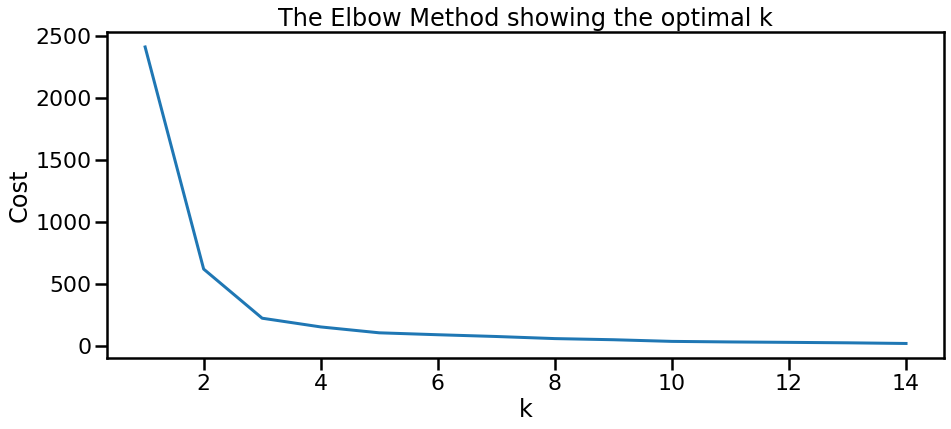

In [52]:
plt.figure(figsize=(15,6))
sns.set_context('poster')
plt.plot(pd.DataFrame(cost)[0], pd.DataFrame(cost)[1])
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('The Elbow Method showing the optimal k') 
plt.show()

In [53]:
from sklearn.metrics import silhouette_score

In [54]:
s_score = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(chicago_grouped_clustering)
    s_score.append([k, silhouette_score(chicago_grouped_clustering, kmeans.labels_)])

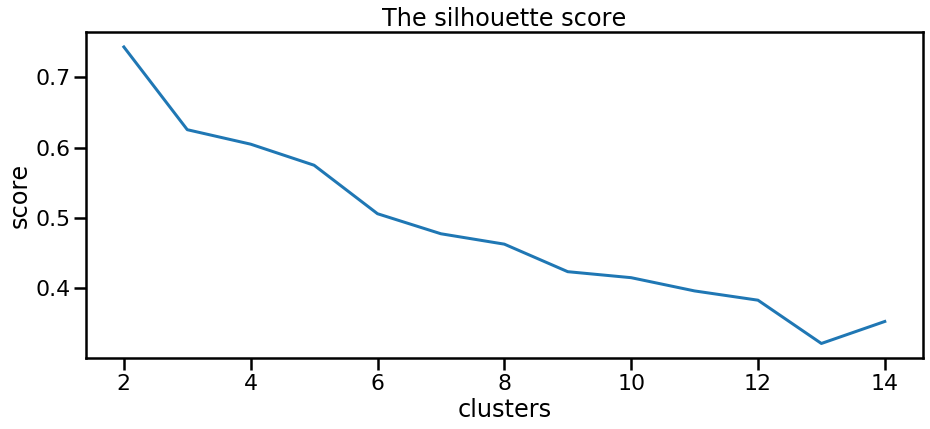

In [55]:
plt.figure(figsize=(15,6))
sns.set_context('poster')
plt.plot( pd.DataFrame(s_score)[0], pd.DataFrame(s_score)[1])
plt.xlabel('clusters')
plt.ylabel('score')
plt.title('The silhouette score') 
plt.show()

### From the above two Graphs it is very much clear that K=2 is optimal.  

**Elbow is formed at n=2 and value of Silhouette Score is also greater at n=2**

In [56]:
# set number of clusters
kclusters = 2

chicago_grouped_clustering = chicago_movie_theaters_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [57]:
CMT_results = pd.DataFrame(kmeans.cluster_centers_)
CMT_results.columns = chicago_grouped_clustering.columns
CMT_results.index = ['cluster0','cluster1']
CMT_results['Total Sum'] = CMT_results.sum(axis = 1)
CMT_results

,Indie Movie Theater,Movie Theater,Multiplex,Theater,Total,Total Sum
cluster0,1.481481,1.962963,0.481481,0.074074,4.0,8.0
cluster1,3.000000,15.250000,3.750000,0.000000,22.0,44.0


In [58]:
CMT_results_merged = pd.DataFrame(chicago_movie_theaters_grouped['Neighborhood'],)

CMT_results_merged['Total'] = chicago_movie_theaters_grouped['Total']
CMT_results_merged = CMT_results_merged.assign(Cluster_Labels = kmeans.labels_)
CMT_results_merged

,Neighborhood,Total,Cluster_Labels
0,Ashburn,1,0
1,Brighton Park,1,0
2,Calumet River,1,0
3,Dunning,1,0
4,Edgewater Glen,8,0
5,Englewood,1,0
6,Goose Island,10,0
7,Graceland West,9,0
8,Gresham,1,0
9,Hanson Park,1,0


**Joining The cluster labels with the original DataFrame**

In [59]:
chicago_df

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville
6,60638,41.78145,-87.77056,Chicago,IL,Illinois,55026.0,1913.0,Cook,"[41.7814, -87.7706]",Clearing (W)
7,60652,41.74795,-87.71479,Chicago,IL,Illinois,40959.0,3153.6,Cook,"[41.748, -87.7148]",Ashburn
8,60626,42.00903,-87.66963,Chicago,IL,Illinois,50139.0,11355.1,Cook,"[42.009, -87.6696]",Rogers Park
9,60615,41.80223,-87.60272,Chicago,IL,Illinois,40603.0,7086.4,Cook,"[41.8022, -87.6027]",Hyde Park
10,60621,41.77638,-87.63944,Chicago,IL,Illinois,35912.0,3718.9,Cook,"[41.7764, -87.6394]",Englewood


In [60]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_df_merge = chicago_df
chicago_df_merge = chicago_df_merge.join(CMT_results_merged.set_index('Neighborhood'), on='Neighborhood')

In [61]:
# chicago_df_merge['Cluster_Labels']=chicago_df_merge['Cluster_Labels'].astype('int64')
# chicago_df_merge['Cluster_Labels'] = np.where(chicago_df_merge['Cluster_Labels'] == np.nan, 0, 1)

The clustering we performed was for NeigbourHoods which only had movie theaters, but after joining with original data we found that many neighbourhoods didn't even had any movie theater. So, for sake of analysis and visulaizations we will them with our own cluster value

In [62]:
chicago_df_merge['Cluster_Labels'].fillna(2, inplace=True)

In [63]:
chicago_df_merge['Cluster_Labels']=chicago_df_merge['Cluster_Labels'].astype('int64')

In [64]:
chicago_df_merge['Total'].fillna(0, inplace=True)

In [65]:
chicago_df_merge.head() 

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square,7.0,0
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park,1.0,0
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village,5.0,0
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park,0.0,2
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville,23.0,1


In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
kclusters=3
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_df_merge['lat'], chicago_df_merge['lng'], chicago_df_merge['Neighborhood'], chicago_df_merge['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#     print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Markets with few installments

In [67]:
chicago_df_merge[chicago_df_merge['Cluster_Labels'] == 0].reset_index(drop=True)

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square,7.0,0
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park,1.0,0
2,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village,5.0,0
3,60652,41.74795,-87.71479,Chicago,IL,Illinois,40959.0,3153.6,Cook,"[41.748, -87.7148]",Ashburn,1.0,0
4,60626,42.00903,-87.66963,Chicago,IL,Illinois,50139.0,11355.1,Cook,"[42.009, -87.6696]",Rogers Park,7.0,0
5,60615,41.80223,-87.60272,Chicago,IL,Illinois,40603.0,7086.4,Cook,"[41.8022, -87.6027]",Hyde Park,3.0,0
6,60621,41.77638,-87.63944,Chicago,IL,Illinois,35912.0,3718.9,Cook,"[41.7764, -87.6394]",Englewood,1.0,0
7,60660,41.99110,-87.66604,Chicago,IL,Illinois,42752.0,12796.8,Cook,"[41.9911, -87.666]",Edgewater Glen,8.0,0
8,60640,41.97236,-87.66347,Chicago,IL,Illinois,65790.0,10530.6,Cook,"[41.9724, -87.6635]",Uptown,6.0,0
9,60614,41.92280,-87.65139,Chicago,IL,Illinois,66617.0,8244.5,Cook,"[41.9228, -87.6514]",Sheffield Neighbors,6.0,0


### Conjusted Markets

In [68]:
chicago_df_merge[chicago_df_merge['Cluster_Labels'] == 1].reset_index(drop=True)

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville,23.0,1
1,60604,41.87814,-87.62837,Chicago,IL,Illinois,570.0,2376.8,Cook,"[41.8781, -87.6284]",The Loop,24.0,1
2,60605,41.86684,-87.61983,Chicago,IL,Illinois,24668.0,7647.5,Cook,"[41.8668, -87.6198]",South Loop,21.0,1
3,60654,41.89227,-87.63729,Chicago,IL,Illinois,14875.0,10154.9,Cook,"[41.8923, -87.6373]",River North,20.0,1


### Untapped Markets

In [69]:
chicago_df_merge[chicago_df_merge['Total'] == 0].reset_index(drop=True)

,ZIP,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park,0.0,2
1,60638,41.78145,-87.77056,Chicago,IL,Illinois,55026.0,1913.0,Cook,"[41.7814, -87.7706]",Clearing (W),0.0,2
2,60645,42.00853,-87.69481,Chicago,IL,Illinois,45274.0,7743.1,Cook,"[42.0085, -87.6948]",West Rogers Park,0.0,2
3,60643,41.69957,-87.66277,Chicago,IL,Illinois,49952.0,2625.0,Cook,"[41.6996, -87.6628]",East Beverly,0.0,2
4,60631,41.99475,-87.81316,Chicago,IL,Illinois,28641.0,2971.5,Cook,"[41.9948, -87.8132]",Norwood Park West,0.0,2
5,60646,41.99304,-87.75962,Chicago,IL,Illinois,27177.0,2295.2,Cook,"[41.993, -87.7596]",Edgebrook,0.0,2
6,60628,41.69182,-87.61797,Chicago,IL,Illinois,72202.0,2553.0,Cook,"[41.6918, -87.618]",Roseland,0.0,2
7,60625,41.97335,-87.70014,Chicago,IL,Illinois,78651.0,7837.6,Cook,"[41.9734, -87.7001]",Ravenswood,0.0,2
8,60636,41.77576,-87.66912,Chicago,IL,Illinois,40916.0,4038.1,Cook,"[41.7758, -87.6691]",West Englewood,0.0,2
9,60617,41.71591,-87.55431,Chicago,IL,Illinois,84155.0,2345.8,Cook,"[41.7159, -87.5543]",South Deering,0.0,2


### Checking which Neighborhoods have land for purchase

In [70]:
df_city_owned=pd.read_csv('City-Owned_Land_Inventory.csv')
df_city_owned.head()

,ID,PIN,Address,Legal Description,Property Status,Date of Acquisition,Date of Disposition,Sq. Ft.,Ward,Community Area Number,Community Area Name,Zoning Classification,Zip Code,Last Update,X Coordinate,Y Coordinate,Latitude,Longitude,Location,Boundaries - ZIP Codes,Community Areas,Zip Codes,Census Tracts,Wards,:@computed_region_awaf_s7ux
0,59392,20-22-108-043-0000,6640 S DR MARTIN LUTHER KING JR DR,NaN,Sold,NaN,11/20/2018,0.0,20.0,69.0,GREATER GRAND CROSSING,C1-2,0.0,12/05/2018,1180026.562,1860895.082,41.773566,-87.615612,"(41.77356594295488, -87.61561170232743)",60.0,67.0,22260.0,122.0,4.0,53.0
1,8901,16-11-109-010-0000,3945 W ERIE ST,NaN,Sold,NaN,03/20/2018,0.0,37.0,23.0,HUMBOLDT PARK,RS-3,60624.0,03/05/2019,1149814.932,1904114.557,41.892804,-87.725240,"(41.892804455312486, -87.72524016744184)",30.0,24.0,21572.0,584.0,45.0,41.0
2,59389,20-22-100-022-0000,37 E 63RD ST,NaN,Sold,NaN,11/20/2018,0.0,20.0,69.0,GREATER GRAND CROSSING,C2-1,60603.0,12/05/2018,1177737.501,1863185.301,41.779903,-87.623934,"(41.779902658099545, -87.62393357311723)",60.0,67.0,22260.0,122.0,4.0,53.0
3,62117,19-10-119-054-8001,NaN,NaN,Sold,NaN,09/29/2017,NaN,NaN,NaN,NaN,NaN,NaN,03/28/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24250,25-16-404-029-0000,10730 S PERRY AVE,NaN,Owned by City,09/26/1991,NaN,0.0,34.0,49.0,ROSELAND,RS-3,60628.0,06/03/2019,1177466.139,1833665.223,41.698902,-87.625818,"(41.69890206136325, -87.62581816617974)",19.0,45.0,21861.0,524.0,22.0,45.0


In [71]:
df_city_owned=df_city_owned[df_city_owned['Property Status']=='Owned by City']

In [72]:
df_city_owned.head()

,ID,PIN,Address,Legal Description,Property Status,Date of Acquisition,Date of Disposition,Sq. Ft.,Ward,Community Area Number,Community Area Name,Zoning Classification,Zip Code,Last Update,X Coordinate,Y Coordinate,Latitude,Longitude,Location,Boundaries - ZIP Codes,Community Areas,Zip Codes,Census Tracts,Wards,:@computed_region_awaf_s7ux
4,24250,25-16-404-029-0000,10730 S PERRY AVE,NaN,Owned by City,09/26/1991,NaN,0.0,34.0,49.0,ROSELAND,RS-3,60628.0,06/03/2019,1177466.139,1833665.223,41.698902,-87.625818,"(41.69890206136325, -87.62581816617974)",19.0,45.0,21861.0,524.0,22.0,45.0
5,37276,25-19-410-039-0000,11747 S VINCENNES AVE,NaN,Owned by City,08/08/2006,NaN,0.0,34.0,75.0,MORGAN PARK,RS-2,60643.0,06/03/2019,1165429.469,1826780.808,41.680273,-87.670085,"(41.68027292633825, -87.67008495866928)",13.0,74.0,22212.0,378.0,22.0,45.0
6,24205,25-05-212-030-0000,8830 S MORGAN ST,NaN,Owned by City,09/30/1997,NaN,0.0,21.0,71.0,AUBURN GRESHAM,RS-2,60620.0,06/03/2019,1171153.782,1846143.432,41.733284,-87.648568,"(41.73328408936725, -87.64856763614299)",59.0,70.0,21554.0,533.0,13.0,18.0
7,20292,20-28-102-034-0000,7152 S LOWE AVE,NaN,Owned by City,03/19/1991,NaN,0.0,6.0,68.0,ENGLEWOOD,RT-4,60621.0,06/03/2019,1173349.387,1857248.689,41.763710,-87.640196,"(41.76371011681756, -87.64019634945383)",11.0,66.0,21559.0,511.0,32.0,31.0
8,58594,16-16-221-074-0000,510 S CICERO AVE,Lot 82 in Mandell's Subdivision of Lots 14 t...,Owned by City,10/12/1982,NaN,0.0,29.0,25.0,AUSTIN,B3-2,60644.0,06/03/2019,1144437.410,1897109.301,41.873684,-87.745166,"(41.87368407904819, -87.74516624237329)",32.0,26.0,22216.0,69.0,7.0,36.0


In [73]:
df_city_owned.isnull().sum()

ID                                 0
PIN                                0
Address                          366
Legal Description              12752
Property Status                    0
Date of Acquisition            12262
Date of Disposition            14151
Sq. Ft.                          416
Ward                            1790
Community Area Number           1790
Community Area Name             1793
Zoning Classification           1790
Zip Code                         416
Last Update                        0
X Coordinate                     161
Y Coordinate                     161
Latitude                         161
Longitude                        161
Location                         161
Boundaries - ZIP Codes          1790
Community Areas                 1790
Zip Codes                       1790
Census Tracts                   1790
Wards                           1790
:@computed_region_awaf_s7ux     1790
dtype: int64

There are null values even in the zip codes so we nned to extract these by using Latitude, Longitude

In [74]:
df_city_owned.dtypes

ID                               int64
PIN                             object
Address                         object
Legal Description               object
Property Status                 object
Date of Acquisition             object
Date of Disposition             object
Sq. Ft.                        float64
Ward                           float64
Community Area Number          float64
Community Area Name             object
Zoning Classification           object
Zip Code                       float64
Last Update                     object
X Coordinate                   float64
Y Coordinate                   float64
Latitude                       float64
Longitude                      float64
Location                        object
Boundaries - ZIP Codes         float64
Community Areas                float64
Zip Codes                      float64
Census Tracts                  float64
Wards                          float64
:@computed_region_awaf_s7ux    float64
dtype: object

In [75]:
df_city_owned['Zip Code'].dropna(axis=0,inplace=True)
df_city_owned['Zip Code'].isnull().sum()

0

In [76]:
chicago_df_merge.rename(columns={'ZIP': 'Zip Code'}, inplace=True)
chicago_df_merge.head(5)

,Zip Code,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square,7.0,0
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park,1.0,0
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village,5.0,0
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park,0.0,2
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville,23.0,1


In [77]:
df_city_owned['Zip Code'].dropna(axis=0,inplace= True)
df_city_owned['Zip Code']=df_city_owned['Zip Code'].astype('int64')
df_city_owned=df_city_owned[df_city_owned['Zip Code']>0.0]
df_city_owned.head()

,ID,PIN,Address,Legal Description,Property Status,Date of Acquisition,Date of Disposition,Sq. Ft.,Ward,Community Area Number,Community Area Name,Zoning Classification,Zip Code,Last Update,X Coordinate,Y Coordinate,Latitude,Longitude,Location,Boundaries - ZIP Codes,Community Areas,Zip Codes,Census Tracts,Wards,:@computed_region_awaf_s7ux
4,24250,25-16-404-029-0000,10730 S PERRY AVE,NaN,Owned by City,09/26/1991,NaN,0.0,34.0,49.0,ROSELAND,RS-3,60628.0,06/03/2019,1177466.139,1833665.223,41.698902,-87.625818,"(41.69890206136325, -87.62581816617974)",19.0,45.0,21861.0,524.0,22.0,45.0
5,37276,25-19-410-039-0000,11747 S VINCENNES AVE,NaN,Owned by City,08/08/2006,NaN,0.0,34.0,75.0,MORGAN PARK,RS-2,60643.0,06/03/2019,1165429.469,1826780.808,41.680273,-87.670085,"(41.68027292633825, -87.67008495866928)",13.0,74.0,22212.0,378.0,22.0,45.0
6,24205,25-05-212-030-0000,8830 S MORGAN ST,NaN,Owned by City,09/30/1997,NaN,0.0,21.0,71.0,AUBURN GRESHAM,RS-2,60620.0,06/03/2019,1171153.782,1846143.432,41.733284,-87.648568,"(41.73328408936725, -87.64856763614299)",59.0,70.0,21554.0,533.0,13.0,18.0
7,20292,20-28-102-034-0000,7152 S LOWE AVE,NaN,Owned by City,03/19/1991,NaN,0.0,6.0,68.0,ENGLEWOOD,RT-4,60621.0,06/03/2019,1173349.387,1857248.689,41.763710,-87.640196,"(41.76371011681756, -87.64019634945383)",11.0,66.0,21559.0,511.0,32.0,31.0
8,58594,16-16-221-074-0000,510 S CICERO AVE,Lot 82 in Mandell's Subdivision of Lots 14 t...,Owned by City,10/12/1982,NaN,0.0,29.0,25.0,AUSTIN,B3-2,60644.0,06/03/2019,1144437.410,1897109.301,41.873684,-87.745166,"(41.87368407904819, -87.74516624237329)",32.0,26.0,22216.0,69.0,7.0,36.0


In [78]:
df_city_owned['Zip Code']=df_city_owned['Zip Code'].astype('int64')
df_city_owned['Zip Code'].dtypes

dtype('int64')

In [79]:
df_city_owned.groupby(['Zip Code'])['Zip Code'].agg({'Count': 'count'}).reset_index(0).head(5)

/home/absoluit-ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


,Zip Code,Count
0,60601,6
1,60602,1
2,60603,1
3,60604,2
4,60605,11


In [80]:
chicago_df_merge

,Zip Code,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square,7.0,0
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park,1.0,0
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village,5.0,0
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park,0.0,2
5,60611,41.89472,-87.61938,Chicago,IL,Illinois,28718.0,13562.3,Cook,"[41.8947, -87.6194]",Streeterville,23.0,1
6,60638,41.78145,-87.77056,Chicago,IL,Illinois,55026.0,1913.0,Cook,"[41.7814, -87.7706]",Clearing (W),0.0,2
7,60652,41.74795,-87.71479,Chicago,IL,Illinois,40959.0,3153.6,Cook,"[41.748, -87.7148]",Ashburn,1.0,0
8,60626,42.00903,-87.66963,Chicago,IL,Illinois,50139.0,11355.1,Cook,"[42.009, -87.6696]",Rogers Park,7.0,0
9,60615,41.80223,-87.60272,Chicago,IL,Illinois,40603.0,7086.4,Cook,"[41.8022, -87.6027]",Hyde Park,3.0,0
10,60621,41.77638,-87.63944,Chicago,IL,Illinois,35912.0,3718.9,Cook,"[41.7764, -87.6394]",Englewood,1.0,0


In [81]:
zips=df_city_owned['Zip Code'].unique().tolist()

In [82]:
df_available=chicago_df_merge[chicago_df_merge['Zip Code'].isin(zips)]

In [83]:
df_available[df_available['Total']<10]

,Zip Code,lat,lng,city,state_id,state_name,population,density,county_name,coord_pairs,Neighborhood,Total,Cluster_Labels
0,60647,41.92068,-87.70167,Chicago,IL,Illinois,87291.0,8385.0,Cook,"[41.9207, -87.7017]",Palmer Square,7.0,0
1,60639,41.92056,-87.75603,Chicago,IL,Illinois,90407.0,7156.5,Cook,"[41.9206, -87.756]",Hanson Park,1.0,0
3,60622,41.90274,-87.68331,Chicago,IL,Illinois,52548.0,8213.0,Cook,"[41.9027, -87.6833]",Ukrainian Village,5.0,0
4,60651,41.90206,-87.74095,Chicago,IL,Illinois,64267.0,7099.1,Cook,"[41.9021, -87.741]",West Humboldt Park,0.0,2
6,60638,41.78145,-87.77056,Chicago,IL,Illinois,55026.0,1913.0,Cook,"[41.7814, -87.7706]",Clearing (W),0.0,2
7,60652,41.74795,-87.71479,Chicago,IL,Illinois,40959.0,3153.6,Cook,"[41.748, -87.7148]",Ashburn,1.0,0
8,60626,42.00903,-87.66963,Chicago,IL,Illinois,50139.0,11355.1,Cook,"[42.009, -87.6696]",Rogers Park,7.0,0
9,60615,41.80223,-87.60272,Chicago,IL,Illinois,40603.0,7086.4,Cook,"[41.8022, -87.6027]",Hyde Park,3.0,0
10,60621,41.77638,-87.63944,Chicago,IL,Illinois,35912.0,3718.9,Cook,"[41.7764, -87.6394]",Englewood,1.0,0
11,60645,42.00853,-87.69481,Chicago,IL,Illinois,45274.0,7743.1,Cook,"[42.0085, -87.6948]",West Rogers Park,0.0,2


**Results:** So, these are the Neighborhoods that don't have enough Movie Theaters or don't have any.

### Further Analysis

At this pont we can tell our client about these locations, if they want to go ahead with their plans further analysis can be done on whether such installment is allowed in these areas or not. Or whether the areas available for purchase are suitable for Movie theaters e.g. such sq/ft etc. all these locations have enough population living within these areas and could be excited and attracted to a new addiction to their neihborhood.